# Project: Advanced Lane Finding - PreProcessing

### Preprocessing
1. Calculate distortion coefficients, camera mtx
2. Calcuate perspective transform matrix

### Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

### 1. Camera Calibration

In [2]:
# prepare object points
def get_object_image_points(images, nx=9, ny=6, debug=False):
    """Iterates through calibration images, find corners and 
    returns object points, image points (for camera calibration).
    Set debug to true to see found corners"""
    
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[range(nx),range(ny)].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            if debug:
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
    if debug:
        cv2.destroyAllWindows()
    return objpoints, imgpoints

In [3]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def calibrate_camera(glob_key='camera_cal/calibration*.jpg', nx=9, ny=6, debug=False):
    # Make a list of calibration images
    images = glob.glob(glob_key)
    
    # Get Object, Image Points
    objpoints, imgpoints = get_object_image_points(images=images, nx=nx, ny=ny, debug=debug)
    
    # Get Camera Image Size
    image_size=cv2.imread(images[0]).shape[1::-1]
    
    # Calibrate Camera from Object Points, Image Points
    retval, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
        
    if debug:
        # Show undistorted images
        for fname in images:
            img = cv2.imread(fname)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistort_image(img, mtx=mtx, dist=dist))
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return mtx, dist

In [4]:
mtx, dist = calibrate_camera(glob_key='camera_cal/calibration*.jpg', nx=9, ny=6, debug=False)

### 2. Calcuate Perspective Transform Matrix

#### Reuse code from project 1 to get lane lines for perspective view

In [5]:
from SimpleLaneFinding import simple_line_finding

In [6]:
img_straight_lines = mpimg.imread("test_images/straight_lines1.jpg")

img_simple_lines, lane_lines = simple_line_finding(img_straight_lines)

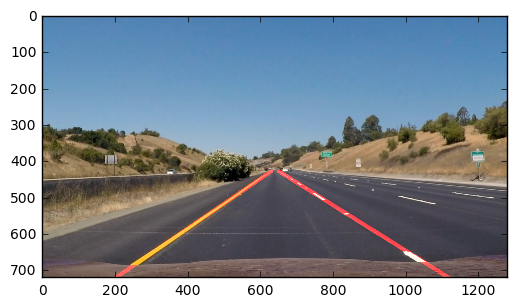

In [7]:
plt.imshow(img_simple_lines)

In [8]:
print(lane_lines)

[[[ 650  429 1115  720]]

 [[ 629  429  204  720]]]


#### Perspective Transform Functions

In [9]:
def get_perspective_matrix(src, dst):
    """
    Calculate and return perspective transform matrix M from 'src', 'dst' points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(img, M):
    """
    `img` is the undistored image
    `M` is the perspective transform matrix
    """
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)
    return warped

In [10]:
def get_point_between(pt1, pt2, fraction):
    return pt1 + fraction*(pt2 - pt1)

In [11]:
def lane_lines_to_src_dst(lane_lines, y_size):
    left_x_bottom = lane_lines[1][0][2]
    left_x_top = lane_lines[1][0][0]
    left_y_bottom = lane_lines[1][0][3]
    left_y_top = lane_lines[1][0][1]

    right_x_bottom = lane_lines[0][0][2]
    right_x_top = lane_lines[0][0][0]
    right_y_bottom = lane_lines[0][0][3]
    right_y_top = lane_lines[0][0][1]

    left_x_top_adj = get_point_between(left_x_bottom, left_x_top, 0.93)
    left_y_top_adj = get_point_between(left_y_bottom, left_y_top, 0.93)
    left_x_bottom_adj = get_point_between(left_x_bottom, left_x_top, 0.05)
    left_y_bottom_adj = get_point_between(left_y_bottom, left_y_top, 0.05)

    right_x_top_adj = get_point_between(right_x_bottom, right_x_top, 0.93)
    right_y_top_adj = get_point_between(right_y_bottom, right_y_top, 0.93)
    right_x_bottom_adj = get_point_between(right_x_bottom, right_x_top, 0.05)
    right_y_bottom_adj = get_point_between(right_y_bottom, right_y_top, 0.05)

    src = np.float32([
            [left_x_bottom_adj, left_y_bottom_adj],
            [left_x_top_adj, left_y_top_adj],
            [right_x_bottom_adj, right_y_bottom_adj],
            [right_x_top_adj, right_y_top_adj]
        ])

    left_x_warp = get_point_between(left_x_bottom_adj, right_x_bottom_adj, 0.15)
    right_x_warp = get_point_between(left_x_bottom_adj, right_x_bottom_adj, 0.85)

    dst = np.float32([
            [left_x_warp, y_size],
            [left_x_warp, 0],
            [right_x_warp, y_size],
            [right_x_warp, 0],
        ])
    return src, dst

In [12]:
src, dst = lane_lines_to_src_dst(lane_lines=lane_lines, y_size=img_straight_lines.shape[0])
M = get_perspective_matrix(src, dst)

### Save Camera Calibration & Perspective Transform Matrices

In [13]:
data = {'mtx':mtx, 'dist':dist, 'M':M}

In [14]:
with open('cameraCalibration_perspectiveTransform_matrices.pkl', 'wb') as f:
    pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

### Testing

In [15]:
img_undistort = undistort_image(img=img_straight_lines, mtx=mtx, dist=dist)
img_unwarp = warp_perspective(img=img_undistort, M=M)

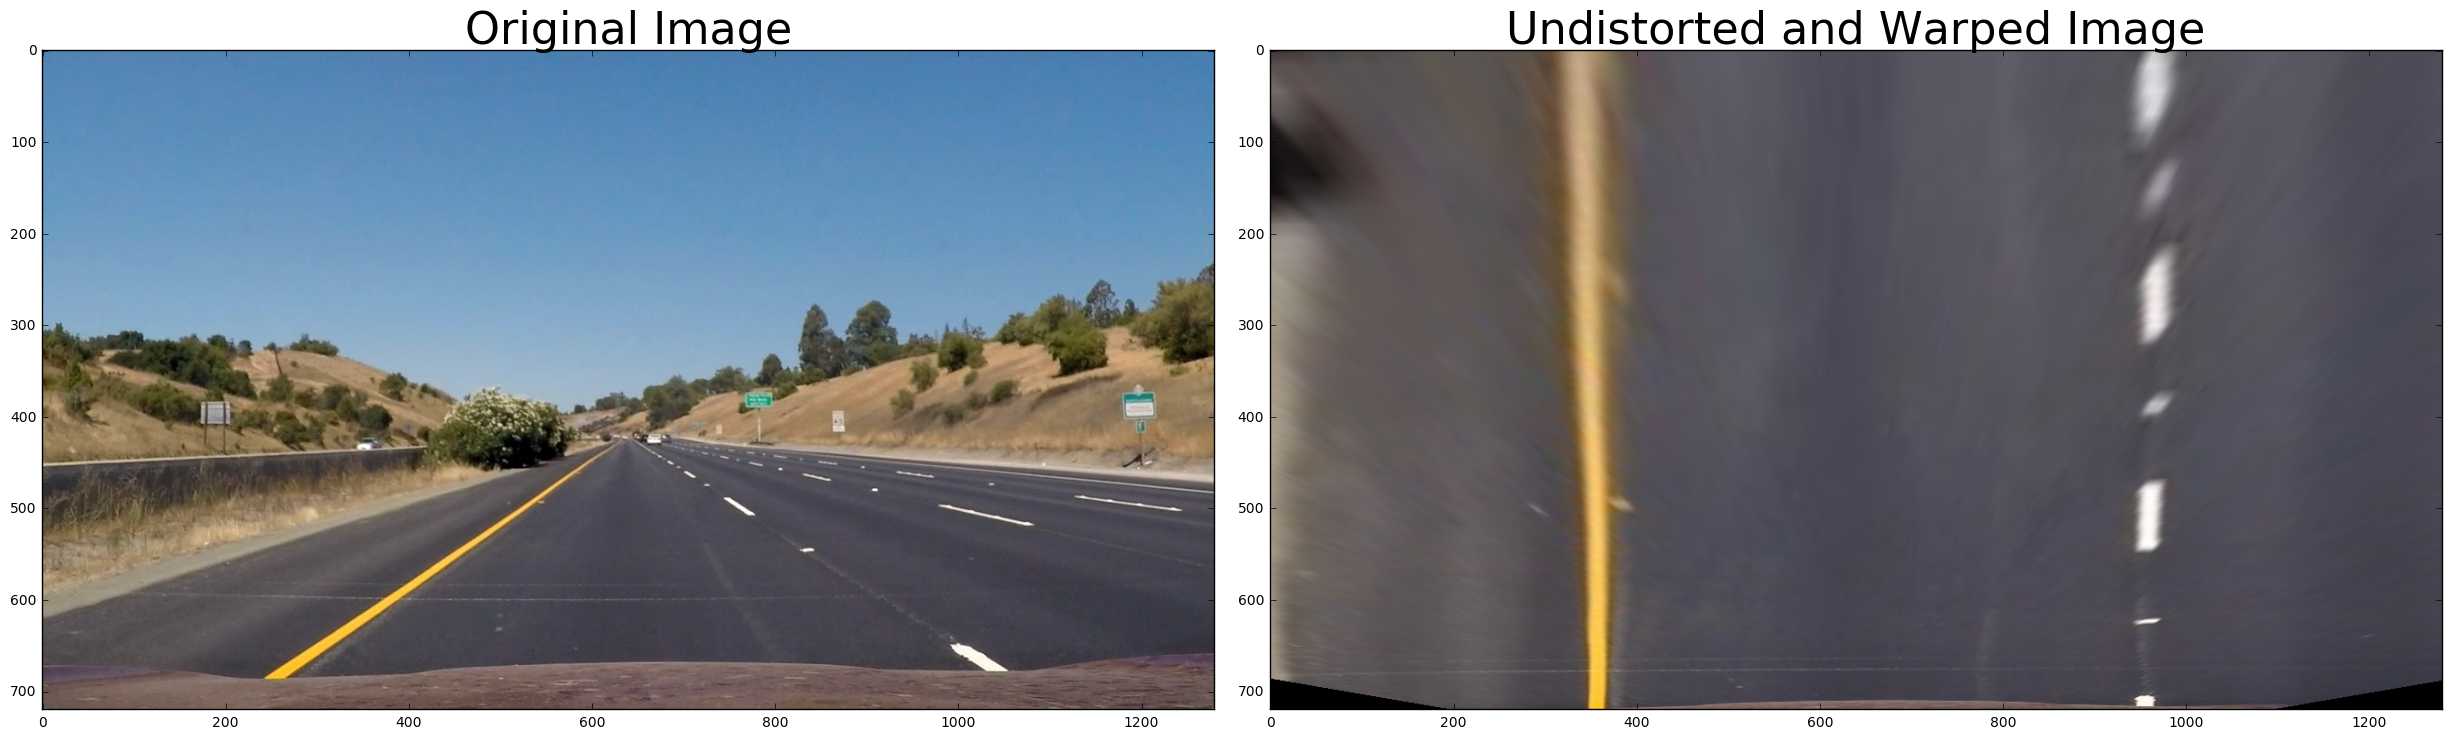

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_straight_lines)
ax1.set_title('Original Image', fontsize=32)
ax2.imshow(img_unwarp)
ax2.set_title('Undistorted and Warped Image', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)